In [1]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

In [ ]:
# user choose -p ... or -sp ...
# extract sub-sample in mapping_population to temporary_sample.txt
# run bcftools view -S temporary_sample.txt to extract temporary_sample.vcf
# run plink pca with .vcf file to obtain eigenvec and eigenval files
# plot to show result

In [2]:
def ancestry_pca(p=None, sp=None,
                       mapping_data='database/mapping_population.csv',
                       data_vcf='database/ALL.chr20.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz',
                       output_temp='output_temp',
                       output_figure='output_figure'):
    # check p and sp
    if p == None and sp == None:
        raise(Exception('No population was selected'))
    elif p != None and sp != None:
        raise(Exception('Choose only population (-p) or super population (-sp)'))
    
    # extract sub-samples in mapping_population to temporary_sample.txt
    mapping_population = pd.read_csv(mapping_data)
    if p != None:
        samples = mapping_population[mapping_population['Population'].isin(p.split())]['Individual ID']
    else:
        samples = mapping_population[mapping_population['Super population'].isin(sp.split())]['Individual ID']
    
    if samples.shape[0] == 0:
        raise(Exception('Population or super population not found'))
    
    samples.to_csv(f'{output_temp}/temporary_sample.txt', index=None, header=False)
    
    # run bcftools to extract vcf
    os.system(command=f'bcftools view -S {output_temp}/temporary_sample.txt {data_vcf} -Oz -o {output_temp}/temporary_sample.vcf.gz')

    # run plink pca with .vcf file to obtain eigenvec and eigenval files
    os.system(command=f'plink --vcf {output_temp}/temporary_sample.vcf.gz \
                            --maf 0.05 --geno 0.05 --mind 0.05 \
                            --pca 10 --out {output_temp}/temporary_pca')
    
    # read eigenvec and eigenval files
    eigenvec = pd.read_table(f'{output_temp}/temporary_pca.eigenvec', header=None, sep=' ')
    eigenval = pd.read_table(f'{output_temp}/temporary_pca.eigenval', header=None)

    # calculate percentile of eigen values (% variance explained)
    eigen_per = round(eigenval.iloc[:, 0] / sum(eigenval.iloc[:, 0]) *100, 2)

    # mapping population
    eigenvec = eigenvec.loc[:, [1, 2, 3]].rename(columns={1:'Individual ID', 2:'PC1', 3:'PC2'})
    eigenvec = pd.merge(eigenvec, mapping_population)

    # plot
    ax = plt.figure(figsize=(8, 6))
    if p != None:
        output_file = '_'.join(p.split())
        sns.scatterplot(x='PC1', y='PC2', data=eigenvec, hue='Population', s=12).set(
                        title='Population with PC1 and PC2', 
                        xlabel=f'PC1 ({eigen_per[0]}% variance explained)',
                        ylabel=f'PC2 ({eigen_per[1]}% variance explained)')
    else:
        output_file = '_'.join(sp.split())
        sns.scatterplot(x='PC1', y='PC2', data=eigenvec, hue='Super population', s=12).set(
                        title='Super population with PC1 and PC2', 
                        xlabel=f'PC1 ({eigen_per[0]}% variance explained)',
                        ylabel=f'PC2 ({eigen_per[1]}% variance explained)')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

    ax.savefig(f'{output_figure}/{output_file}' + '.png', dpi=150, bbox_inches='tight')

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to output_temp/temporary_pca.log.
Options in effect:
  --geno 0.05
  --maf 0.05
  --mind 0.05
  --out output_temp/temporary_pca
  --pca 10
  --vcf output_temp/temporary_sample.vcf.gz

64187 MB RAM detected; reserving 32093 MB for main workspace.
--vcf: output_temp/temporary_pca-temporary.bed +
output_temp/temporary_pca-temporary.bim +
output_temp/temporary_pca-temporary.fam written.
1812841 variants loaded from .bim file.
660 people (0 males, 0 females, 660 ambiguous) loaded from .fam.
Ambiguous sex IDs written to output_temp/temporary_pca.nosex .
0 people removed due to missing genotype data (--mind).
Using up to 19 threads (change this with --threads).
Before main variant filters, 660 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243

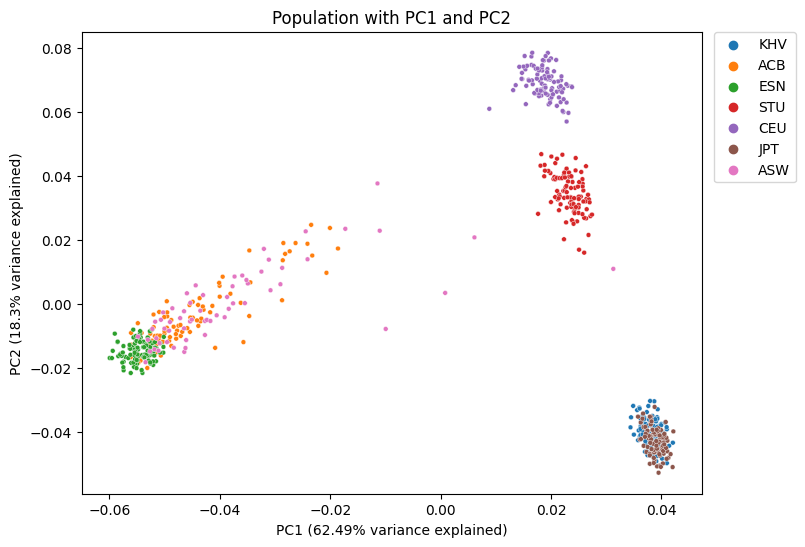

In [3]:
ancestry_pca(p="ASW ACB KHV JPT STU CEU ESN")